In [ ]:
## Aniposelib triangulation

In [1]:
import numpy as np
import os
import pandas as pd
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
# from aniposelib.utils import load_pose2d_fnames

In [2]:
## Loading calibration from a file
cgroup = CameraGroup.load('/home/yiting/Documents/Anipose_projects/Anipose_240624/calibration/calibration.toml')
cam_names = ['A', 'B']

In [3]:
## convenience function to load a set of Lightning Pose 2d-output files
def load_lp_pose2d(fname_dict, offsets_dict=None, cam_names=None):
    if cam_names is None:
        cam_names = sorted(fname_dict.keys())
    pose_names = [fname_dict[cname] for cname in cam_names]

    if offsets_dict is None:
        offsets_dict = dict([(cname, (0,0)) for cname in cam_names])

    datas = []
    for ix_cam, (cam_name, pose_name) in \
            enumerate(zip(cam_names, pose_names)):
        dlabs = pd.read_hdf(pose_name)
        if len(dlabs.columns.levels) > 2:
            scorer = dlabs.columns.levels[0][0]
            dlabs = dlabs.loc[:, scorer]

        bp_index = dlabs.columns.names.index('bodyparts')
        joint_names = list(dlabs.columns.get_level_values(bp_index).unique())
        dx = offsets_dict[cam_name][0]
        dy = offsets_dict[cam_name][1]

        for joint in joint_names:
            dlabs.loc[:, (joint, 'x')] = dlabs.loc[:, (joint, 'x')].astype(float) + dx
            dlabs.loc[:, (joint, 'y')] = dlabs.loc[:, (joint, 'y')].astype(float) + dy

        datas.append(dlabs)
    n_cams = len(cam_names)
    n_joints = len(joint_names)
    n_frames = min([d.shape[0] for d in datas])

    # frame, camera, bodypart, xy
    points = np.full((n_cams, n_frames, n_joints, 2), np.nan, 'float')
    scores = np.full((n_cams, n_frames, n_joints), np.zeros(1), 'float')

    for cam_ix, dlabs in enumerate(datas):
        for joint_ix, joint_name in enumerate(joint_names):
            try:
                points[cam_ix, :, joint_ix] = np.array(dlabs.loc[:, (joint_name, ('x', 'y'))])[:n_frames]
                scores[cam_ix, :, joint_ix] = np.array(dlabs.loc[:, (joint_name, ('likelihood'))])[:n_frames].ravel()
            except KeyError:
                pass

    return {
        'cam_names': cam_names,
        'points': points,
        'scores': scores,
        'bodyparts': joint_names
    }



In [4]:
# Load LP 2d outputs
fname_dict = {
    'A': '/home/yiting/Documents/Anipose_projects/Anipose_240624/LP_2d_outputs/vid_231121-102936_camA.h5',
    'B': '/home/yiting/Documents/Anipose_projects/Anipose_240624/LP_2d_outputs/vid_231121-102936_camB.h5',
}
d = load_lp_pose2d(fname_dict, cam_names=cgroup.get_names())

In [5]:
# Triangulation

score_threshold = 0.7

n_cams, n_frames, n_joints, _ = d['points'].shape
points = d['points']
scores = d['scores']

bodyparts = d['bodyparts']

# remove points that are below threshold
points[scores < score_threshold] = np.nan

points_flat = points.reshape(n_cams, -1, 2)
scores_flat = scores.reshape(n_cams, -1)

p3ds_flat = cgroup.triangulate(points_flat, progress=True)
reprojerr_flat = cgroup.reprojection_error(p3ds_flat, points_flat, mean=True)

p3ds = p3ds_flat.reshape(n_frames, n_joints, 3)
reprojerr = reprojerr_flat.reshape(n_frames, n_joints)
scores_3d = np.min(scores,axis=0)

good_points = ~np.isnan(points[:, :, :, 0])
num_cams = np.sum(good_points, axis=0).astype('float')
num_cams[num_cams < 2] = np.nan

M = np.identity(3)
center = np.zeros(3)

100%|█████████████████████████| 17100/17100 [00:02<00:00, 6271.69it/s]


In [6]:
# Save 3d data
output_fname = '/home/yiting/Documents/Anipose_projects/Anipose_240624/p3d.csv'
dout = pd.DataFrame()
for bp_num, bp in enumerate(bodyparts):
    for ax_num, axis in enumerate(['x','y','z']):
        dout[bp + '_' + axis] = p3ds[:, bp_num, ax_num]
    dout[bp + '_error'] = reprojerr[:, bp_num]
    dout[bp + '_ncams'] = num_cams[:, bp_num]
    dout[bp + '_score'] = scores_3d[:, bp_num]

for i in range(3):
    for j in range(3):
        dout['M_{}{}'.format(i, j)] = M[i, j]

for i in range(3):
    dout['center_{}'.format(i)] = center[i]
    
dout['fnum'] = np.arange(n_frames)

dout.to_csv(output_fname, index=False)


In [7]:
print(np.nanmean(reprojerr))

24.499499934039328


Text(0.5, 1.0, 'x, y, z coordinates of index_Tip')

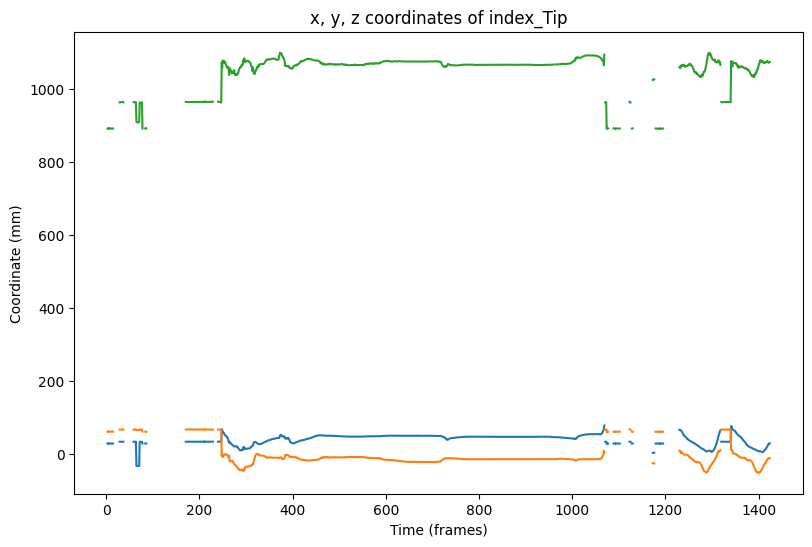

In [9]:
# Visualization

# plot the x, y, z coordinates of joint 0
import matplotlib.pyplot as plt

plt.figure(figsize=(9.4, 6))
plt.plot(p3ds[:, 0, 0])
plt.plot(p3ds[:, 0, 1])
plt.plot(p3ds[:, 0, 2])
plt.xlabel("Time (frames)")
plt.ylabel("Coordinate (mm)")
plt.title("x, y, z coordinates of {}".format(bodyparts[0]))


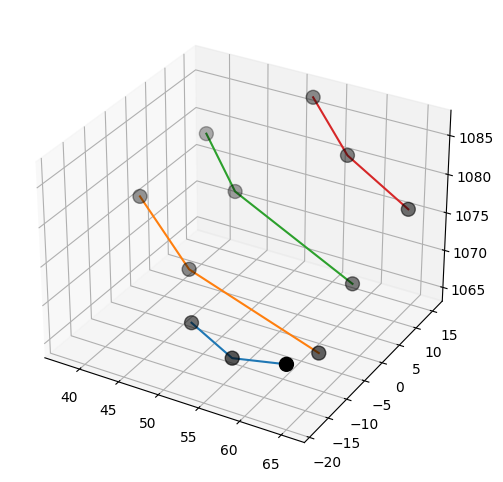

In [10]:
## plot the first frame in 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import get_cmap

def connect(ax, points, bps, bp_dict, color):
    ixs = [bp_dict[bp] for bp in bps]
    return ax.plot(points[ixs, 0], points[ixs, 1], points[ixs, 2], color=color)

def connect_all(ax, points, scheme, bodyparts, cmap=None):
    if cmap is None:
        cmap = get_cmap('tab10')
    bp_dict = dict(zip(bodyparts, range(len(bodyparts))))
    lines = []
    for i, bps in enumerate(scheme):
        line = connect(ax, points, bps, bp_dict, color=cmap(i)[:3])
        lines.append(line)
    return lines

## scheme for the hand
scheme = [
   ["index_PIP", "index_DIP", "index_Tip"],
   ["middle_PIP", "middle_DIP", "middle_Tip"],
   ["ring_PIP", "ring_DIP", "ring_Tip"],
   ["small_PIP", "small_DIP", "small_Tip"]
 ]
# scheme = [
#    ["MCP1", "PIP1", "tip1"],
#    ["MCP2", "PIP2", "DIP2", "tip2"],
#    ["MCP3", "PIP3", "DIP3", "tip3"],
#    ["MCP4", "PIP4", "DIP4", "tip4"],
#    ["MCP5", "PIP5", "DIP5", "tip5"],
#    ["base", "MCP1", "MCP2", "MCP3", "MCP4", "MCP5", "base"]
#  ]

framenum = 500
p3d = p3ds[framenum]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p3d[:,0], p3d[:,1], p3d[:,2], c='black', s=100)
connect_all(ax, p3d, scheme, bodyparts)

plt.show()